## PCB Defect Detection: Object Detection (The Original - V1)

Dataset Source: https://universe.roboflow.com/srtimagedefectdetection-wuadb/pcb-defect-detection-hdqc8

##### Install Necessary Libraries Not Already Installed

In [24]:
%pip install transformers evaluate datasets tensorboard timm coco-eval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for coco-eval: filename=coco_eval-0.0.4-py3-none-any.whl size=5036 sha256=bb51f959284ef76958d8084a70d1a3513c49d88518c82bf570ef7740eacf567f
  Stored in directory: /root/.cache/pip/wheels/51/73/56/423d59979be1af3ec949e6524af7dd5127ba2cbe4b30981afb
Successfully built coco-eval


##### Import Necessary Libraries

In [2]:
import os, sys, json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import albumentations

from PIL import ImageDraw
import PIL.Image
from IPython.display import Image, display

from tqdm import tqdm
import torchvision
import evaluate

import transformers
from transformers import AutoModelForObjectDetection, AutoImageProcessor
from transformers import TrainingArguments, Trainer
from transformers import DetrImageProcessor

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset

import datasets
from datasets import load_dataset

#### Access to HuggingFace Hub

In [3]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as d

##### Display Versions of Relevant Libraries

In [4]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)
print("Torch Vision:".rjust(15), torchvision.__version__)

        Python: 3.9.16
         NumPy: 1.22.4
        Pandas: 1.4.4
  Transformers: 4.27.4
         Torch: 1.13.1+cu116
  Torch Vision: 0.14.1+cu116


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### COCO Detection Class

In [6]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, train=True):
        ann_file = os.path.join(img_folder, "_annotations.coco.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in COCO format of both PIL image & target
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, 
                                  annotations=target, 
                                  return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() #remove batch dimension
        target = encoding["labels"][0] #remove batch dimension

        return pixel_values, target

#### Ingest Data

In [7]:
parent_dir = "/content/drive/MyDrive/PCB Defect Detection"

img_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

train_ds = CocoDetection(img_folder=os.path.join(parent_dir, 'valid'), 
                              processor=img_processor)

eval_ds = CocoDetection(img_folder=os.path.join(parent_dir, 'test'), 
                            processor=img_processor, 
                            train=False)

/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:780: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


loading annotations into memory...
Done (t=3.12s)
creating index...
index created!
loading annotations into memory...
Done (t=2.45s)
creating index...
index created!


In [8]:
print(f"The training dataset has {len(train_ds)} samples in it.")
print(f"The testing dataset has {len(eval_ds)} samples in it.")

The training dataset has 468 samples in it.
The testing dataset has 288 samples in it.


In [9]:
pixel_values, target = train_ds[2]
print(pixel_values.shape)
print(target.keys())

torch.Size([3, 800, 800])
dict_keys(['size', 'image_id', 'class_labels', 'boxes', 'area', 'iscrowd', 'orig_size'])


/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


##### Visualize Example

Image n°116


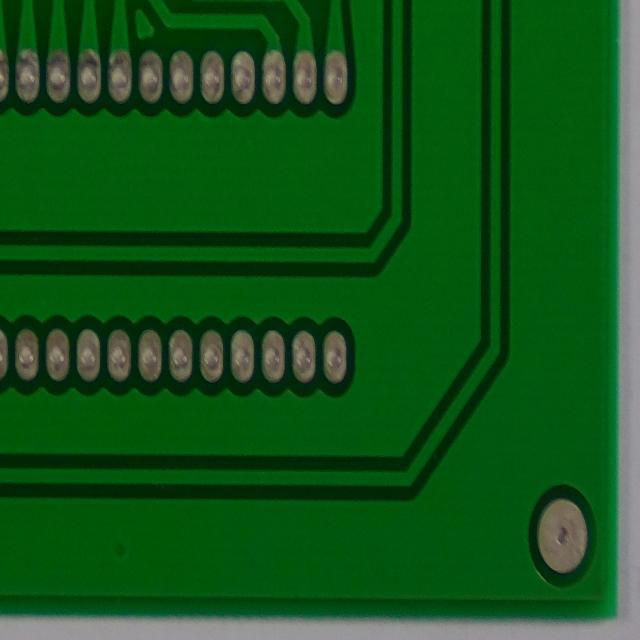

In [10]:
categories = ["missing hole", "mouse bite", "open circuit", "short", "spur", "spurious copper"]
NUM_LABELS = len(categories)

id2label = {k: v for k, v in enumerate(categories)}
label2id = {v: k for k, v in id2label.items()}

image_ids = train_ds.coco.getImgIds()

# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_ds.coco.loadImgs(image_id)[0]
image = PIL.Image.open(os.path.join(parent_dir, "valid", image['file_name']))

annotations = train_ds.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

#### Basic Values/Constants

In [11]:
MODEL_CKPT = "facebook/detr-resnet-50"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-PCB_Defect_Detection"

BATCH_SIZE = 8
DEVICE = torch.device("cuda")

LEARNING_RATE = 1e-5
NUM_OF_EPOCHS = 25

WEIGHT_DECAY = 1e-4
STRATEGY = "epoch"

REPORTS_TO = "tensorboard"

#### Define Data Collator

In [12]:
def collate_function(batch):
  pixel_values = [item[0] for item in batch]
  encoding = img_processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

##### Instantiate Model

In [13]:
model = AutoModelForObjectDetection.from_pretrained(
    MODEL_CKPT,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
).to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Define Training Arguments

In [14]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    per_device_train_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_OF_EPOCHS,
    save_strategy=STRATEGY,
    logging_strategy=STRATEGY,
    logging_first_step=True,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    report_to=REPORTS_TO,
    remove_unused_columns=False,
    fp16=True,
    push_to_hub=True
)

##### Instantiate Trainer

In [15]:
trainer = Trainer(
    model=model,
    args=args,
    data_collator=collate_function,
    train_dataset=train_ds,
    tokenizer=img_processor,
)

Cloning https://huggingface.co/DunnBC22/detr-resnet-50-PCB_Defect_Detection into local empty directory.


##### Train Model

In [16]:
training_results = trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


Step,Training Loss
1,5.585100
59,4.643200
118,3.390400
177,2.789500
236,2.441300
295,2.269200
354,2.055600
413,1.873400
472,1.752200
531,1.653200


/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/usr/local/lib/pytho

In [30]:
training_results

TrainOutput(global_step=1475, training_loss=1.8254104155201023, metrics={'train_runtime': 2531.9655, 'train_samples_per_second': 4.621, 'train_steps_per_second': 0.583, 'total_flos': 5.591514644352e+18, 'train_loss': 1.8254104155201023, 'epoch': 25.0})

#### Push Model to Hub (My Profile!!!!)

In [17]:
trainer.push_to_hub()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/159M [00:00<?, ?B/s]

Upload file runs/Mar29_20-25-01_31d23c897156/events.out.tfevents.1680121509.31d23c897156.176.0:   0%|         …

To https://huggingface.co/DunnBC22/detr-resnet-50-PCB_Defect_Detection
   9adc080..a0eefa9  main -> main

   9adc080..a0eefa9  main -> main

To https://huggingface.co/DunnBC22/detr-resnet-50-PCB_Defect_Detection
   a0eefa9..1175fd5  main -> main

   a0eefa9..1175fd5  main -> main



'https://huggingface.co/DunnBC22/detr-resnet-50-PCB_Defect_Detection/commit/a0eefa90b91260c3112340fefeb5da9454e6b335'

#### Function to Format Dataset for Evaluation 

In [18]:
def eval_formatted_anns(img_id, objects):
    annotations = []
    for i in range(0, len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": img_id,
            "area": objects["area"][i],
            "bbox": objects["bbox"][i],
        }
        annotations.append(new_ann)

    return annotations

#### Save Annotations File 

In [19]:
def save_annotation_file_images(input):
    output_json = {}
    path_output = f"{os.getcwd()}/PCB_defects_Detection/"

    if not os.path.exists(path_output):
        os.makedirs(path_output)

    path_anno = os.path.join(path_output, "PCB_Defects_Detection_ann.json")
    categories_json = [{"supercategory": "none", "id": id, "name": id2label[id]} 
                       for id in id2label]
    output_json["images"] = []
    output_json["annotations"] = []
    for example in input:
        ann = eval_formatted_anns(example["image_id"], example["objects"])
        output_json["images"].append(
            {
                "id": example["image_id"],
                "width": example["image"].width,
                "height": example["image"].height,
                "file_name": f"{example['image_id']}.png",
            }
        )
        output_json["annotations"].extend(ann)
    output_json["categories"] = categories_json

    with open(path_anno, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    for im, img_id in zip(input["image"], input["image_id"]):
        path_img = os.path.join(path_output, f"{img_id}.png")
        im.save(path_img)

    return path_output, path_anno

#### Define CocoDetection Dataset Class

In [ ]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, ann_file):
        super().__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image & target in coco format
        img, target = super(CocoDetection, self).__getitem__(idx)

        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension

        return {"pixel_values": pixel_values, "labels": target}

im_processor = AutoImageProcessor.from_pretrained(MODEL_NAME)

path_output, path_anno = save_annotation_file_images(input["test"])
test_ds_coco_format = CocoDetection(path_output, im_processor, path_anno)

#### Generate Predictions

In [ ]:
model = AutoModelForObjectDetection.from_pretrained(MODEL_NAME)
module = evaluate.load("ybelkada/cocoevaluate", 
                       coco=test_ds_coco_format.coco)

val_dataloader = torch.utils.data.DataLoader(
    test_ds_coco_format, 
    batch_size=8, 
    shuffle=False, 
    num_workers=4, 
    collate_fn=collate_function
)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]  # these are in DETR format, resize & normalize

        # forward pass
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        orig_target_sizes = torch.stack(
            [target["orig_size"] for target in labels]
            , dim=0)
        
        # this converts outputs to COCO
        results = im_processor.post_process(outputs, 
                                            orig_target_sizes)  

        module.add(prediction=results, reference=labels)
        del batch

#### Viola!!!

In [ ]:
results = module.compute()
print(results)

#### Define Functions to Prepare Predictions for Evaluation

In [25]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

#### Calculate & Display Results

In [ ]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

import numpy as np

# initialize evaluator with ground truth (gt)
evaluator = CocoEvaluator(coco_gt=eval_ds.coco, iou_types=["bbox"])

print("Running evaluation...")
for idx, batch in enumerate(tqdm(eval_ds)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(DEVICE)
    pixel_mask = batch["pixel_mask"].to(DEVICE)
    labels = [{k: v.to(DEVICE) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = img_processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)

    # provide to metric
    # metric expects a list of dictionaries, each item 
    # containing image_id, category_id, bbox and score keys 
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

### Notes & Other Takeaways
****
- The toughest part of training both object detection and image segmentation models is that they require better hardware than what I have.
- The training session timed out during evaluation, so I decided to evaluate all of the PCB Defect Detection projects using a separate project/training session.
****

#### Citations

- Model Checkpoint
    > @article{DBLP:journals/corr/abs-2005-12872, author = {Nicolas Carion and Francisco Massa and Gabriel Synnaeve and Nicolas Usunier and Alexander Kirillov and Sergey Zagoruyko}, title = {End-to-End Object Detection with Transformers}, journal = {CoRR}, volume = {abs/2005.12872}, year = {2020}, url = {https://arxiv.org/abs/2005.12872}, archivePrefix = {arXiv}, eprint = {2005.12872}, timestamp = {Thu, 28 May 2020 17:38:09 +0200}, biburl = {https://dblp.org/rec/journals/corr/abs-2005-12872.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}

- Dataset
    > @misc{ pcb-defect-detection-hdqc8_dataset, title = { PCB defect detection Dataset }, type = { Open Source Dataset }, author = { SRTImageDefectDetection }, howpublished = { \url{ https://universe.roboflow.com/srtimagedefectdetection-wuadb/pcb-defect-detection-hdqc8 } }, url = { https://universe.roboflow.com/srtimagedefectdetection-wuadb/pcb-defect-detection-hdqc8 }, journal = { Roboflow Universe }, publisher = { Roboflow }, year = { 2022 }, month = { sep }, note = { visited on 2023-07-30 },}